In [162]:
%load_ext autoreload
%autoreload 2

from base64 import b64encode
import copy
from datetime import datetime
import getopt
import io
from io import BytesIO
import os
import sys

# standard numeric/scientific libraries
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 

# plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('figure', figsize=(20, 12))

# image display
from PIL import Image
import IPython.display 
from IPython.display import HTML

#internal libraries which may or may not get used
import fdls
from lddutils import *

# Notebook-only functions go here

# Draws a uint16 image, downscaled to uint8
def draw_raw_bwimage(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [163]:
import lddecode_core as ldd


In [186]:
#infile = open('/mnt3/dd/War of the worlds_CAV_NTSC_side1_2018-10-03_06-24-34.lds', 'rb')
infile = open('/mnt3/dd/odyssey_side2_2018-09-30_10-46-20.lds', 'rb')
#infile = open('/mnt3/ggv1069_side1_v2800_2018-09-28_07-33-31.lds', 'rb')
infile = open('/mnt3/dd/turtle8_side1_6x_2018-10-13_20-04-02.lds', 'rb')
infile = open('/mnt3/dd/dg-latw_side2_6x_2018-10-14_20-52-38.lds', 'rb')
ldd.loader = ldd.load_packed_data_4_40

outfile = open('tmpntscb.tbc', 'wb')
outfile_audio = open('tmpntscb.pcm', 'wb')

rf_ntsc = ldd.RFDecode(system='NTSC', decode_analog_audio=False)
framer = ldd.Framer(rf_ntsc, full_decode = False)
bytes_per_frame = int(rf_ntsc.freq_hz / rf_ntsc.SysParams['FPS'])

target = 5000

def findframe(infile, rf, target):
    framer = ldd.Framer(rf, full_decode = False)
    
    nextsample = 0
    iscav = False
    rv = framer.readframe(infile, nextsample, CAV=False)
    print(framer.vbi)

    # because of 29.97fps, there may be missing frames
    if framer.vbi['isclv']:
        tolerance = 1
    else:
        tolerance = 0
        iscav = True

    retry = 5
    while np.abs(target - framer.vbi['framenr']) > tolerance and retry:
        offset = (bytes_per_frame * (target - 1 - framer.vbi['framenr'])) 
        nextsample = rv[2] + offset
        rv = framer.readframe(infile, nextsample, CAV=iscav)
        print(framer.vbi)
        retry -= 1

    if np.abs(target - framer.vbi['framenr']) > tolerance:
        print("WARNING: seeked to frame ", framer.vbi['framenr'])
        
    return nextsample
    
findframe(infile, rf_ntsc, 3400)

0
400766402
{'minutes': 0, 'seconds': 0, 'clvframe': 0, 'framenr': 0, 'statuscode': None, 'status': 9290752, 'isclv': True}
7072761736
7073451098
7074119825
{'minutes': 2, 'seconds': 46, 'clvframe': 17, 'framenr': 4997, 'statuscode': None, 'status': 9290752, 'isclv': True}
7076789157
7077455251
7078123674
{'minutes': 2, 'seconds': 46, 'clvframe': 20, 'framenr': 5000, 'statuscode': None, 'status': 9290752, 'isclv': True}


7076789157

In [179]:
(2819187558-400766402)/bytes_per_frame, (1738112069-400766402)/bytes_per_frame

(1812.0047682341499, 1002.0077435103614)

In [170]:
framer.vbi

{'clvframe': None,
 'framenr': 50,
 'isclv': False,
 'minutes': None,
 'seconds': None,
 'status': 9153536,
 'statuscode': None}

In [78]:
rv

(None,
 None,
 302096538,
 302762823,
  <lddecode_core.Field at 0x7f59b8f5d048>])

In [65]:
rv[2] + (bytes_per_frame * (1 - 1 - framer.vbi['framenr']))

235363731

In [148]:
#infile = open('/mnt3/dd/War of the worlds_CAV_NTSC_side1_2018-10-03_06-24-34.lds', 'rb')
infile = open('/mnt3/dd/odyssey_side2_2018-09-30_10-46-20.lds', 'rb')
#infile = open('/mnt3/ggv1069_side1_v2800_2018-09-28_07-33-31.lds', 'rb')
infile = open('/mnt2/ld/dd/ilovela.raw', 'rb')
ldd.loader = ldd.load_unpacked_data_s16
#ldd.loader = ldd.load_packed_data_3_32

outfile = open('tmpntscb.tbc', 'wb')
outfile_audio = open('tmpntscb.pcm', 'wb')

rf_ntsc = ldd.RFDecode(system='NTSC', decode_analog_audio=False)
framer = ldd.Framer(rf_ntsc, full_decode = False)
bytes_per_frame = int(rf_ntsc.freq_hz / rf_ntsc.SysParams['FPS'])

target = 500

nextsample = (bytes_per_frame * 600)
rv = framer.readframe(infile, nextsample, CAV=False)

print(framer.vbi['framenr'], rv[2])
framer.vbi

800799600
801884691
802552830
116 802552830


{'clvframe': 26,
 'framenr': 116,
 'isclv': True,
 'minutes': 0,
 'seconds': 3,
 'status': None,
 'statuscode': None}

In [150]:
(target - 1 - framer.vbi['framenr'])

383

In [154]:
801884691 / bytes_per_frame

600.813005650852

In [161]:
offset = (bytes_per_frame * (target - 1 - framer.vbi['framenr']))
nextsample = rv[2] + offset
#nextsample =  (bytes_per_frame * 300)
rv = framer.readframe(infile, nextsample, CAV=False)

print(framer.vbi['framenr'], offset, nextsample, rv[2])
framer.vbi

TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'

In [137]:
900/30

30.0

In [94]:
rv

(None,
 None,
 3228495271,
 3229161690,
  <lddecode_core.Field at 0x7f59b8b1c630>])

In [113]:
framer.vbi

{'clvframe': 8,
 'framenr': 39878,
 'isclv': True,
 'minutes': 22,
 'seconds': 9,
 'status': 9289728,
 'statuscode': None}

In [98]:
22*(60*30)+(8*30)+6

39846

In [103]:
(23*(60*30))+(9*30)+26

41696

starting at  1334666000
too short 0 467091 [(200, 193, False)]
status code 9153536
False None
starting at  1335799392
status code 9153536
CAV  825
CAV  825
True 825
starting at  1336467765
status code 9153536
False None
524 262 263
frame  825
(458640,)
uint8 (504, 910) (504, 910)


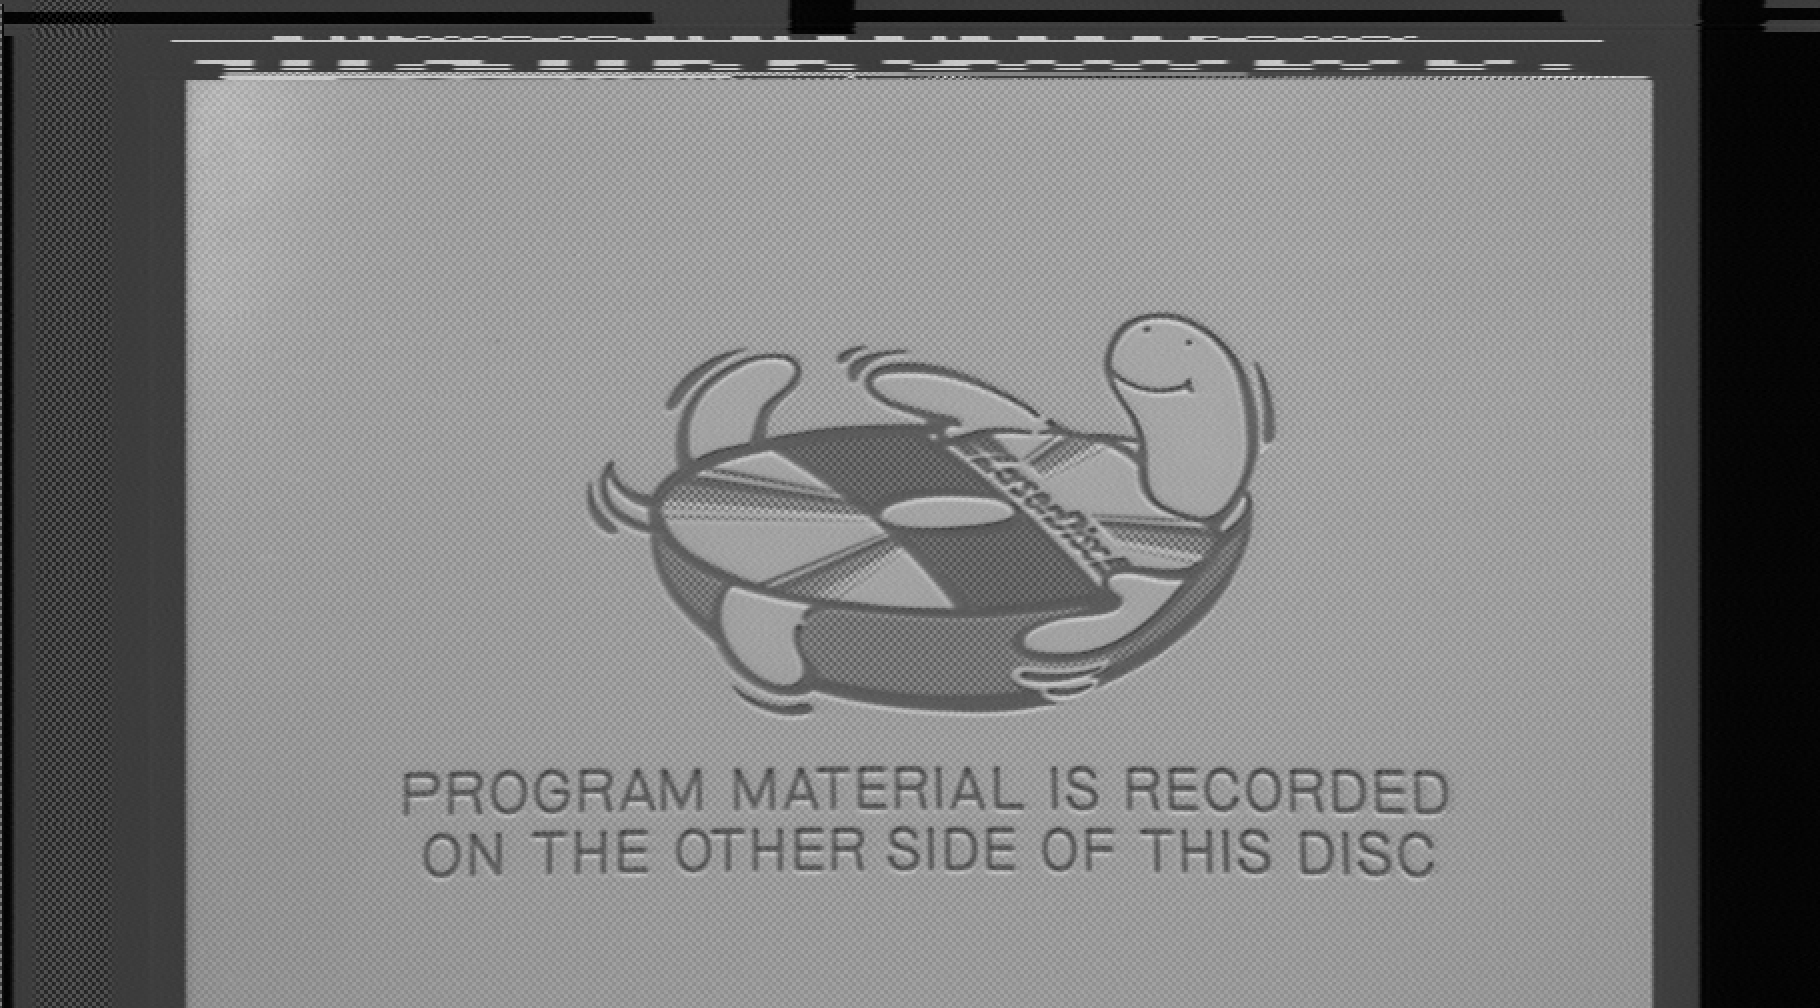

In [48]:
#infile = open('/mnt3/dd/War of the worlds_CAV_NTSC_side1_2018-10-03_06-24-34.lds', 'rb')
infile = open('/mnt3/dd/odyssey_side2_2018-09-30_10-46-20.lds', 'rb')
#infile = open('/mnt3/ggv1069_side1_v2800_2018-09-28_07-33-31.lds', 'rb')
infile = open('/mnt3/dd/turtle8_side1_6x_2018-10-13_20-04-02.lds', 'rb')
ldd.loader = ldd.load_packed_data_4_40

nextsample = 1024*1024*10000
#nextsample = 2059514098
nextsample = 5339921592

outfile = open('tmpntscb.tbc', 'wb')
outfile_audio = open('tmpntscb.pcm', 'wb')

rf_ntsc = ldd.RFDecode(system='NTSC')#, decode_analog_audio=False)
framer_ntsc = ldd.Framer(rf_ntsc)
bytes_per_frame = int(rf_ntsc.freq_hz / rf_ntsc.SysParams['FPS'])

nextsample =  (bytes_per_frame * 1000)
#nextsample = 1507464041

ca = []
for f in range(0,1):
    combined, audio, nextsample, fields = framer_ntsc.readframe(infile, nextsample, f == 0)
    
    print('frame ', framer_ntsc.vbi['framenr'])
    
    ca.append(audio)
    
    outfile.write(combined)
    #print(len(audio)//2)
    #outfile_audio.write(audio)

#draw_raw_bwimage(combined, outwidth, 610, hscale=2, vscale=2)

outfile.close()
outfile_audio.close()

draw_raw_bwimage(combined, 910, 504, hscale=2, vscale=2)

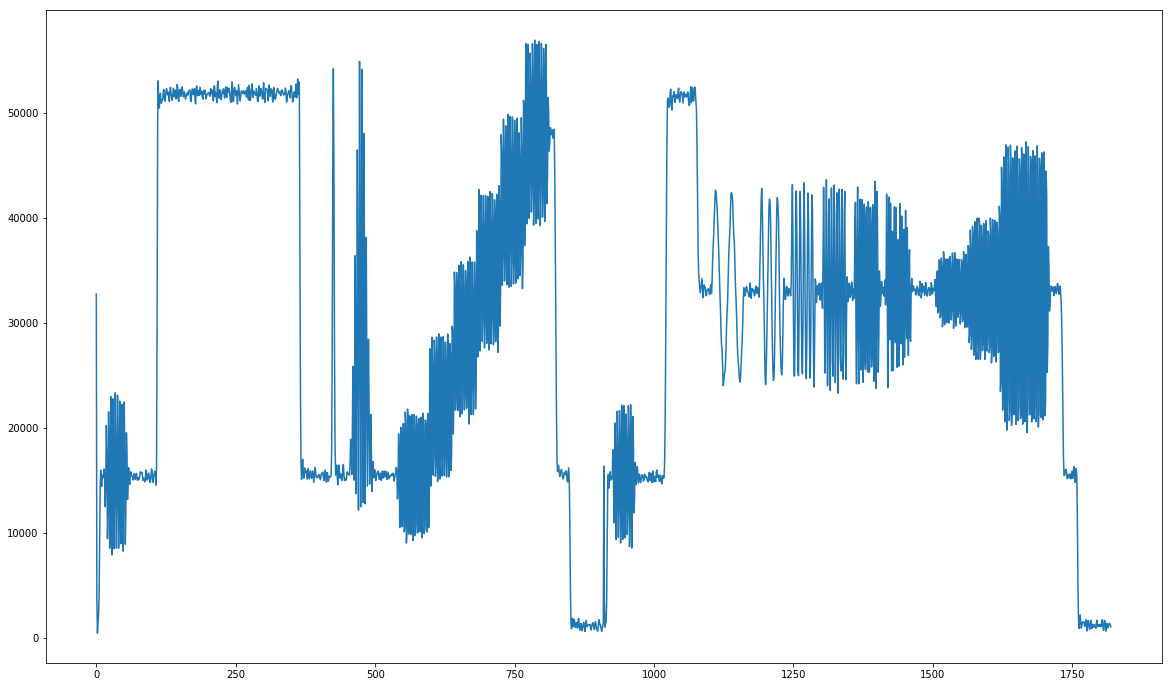

In [53]:
plt.plot(combined[910*38:910*40])

In [15]:
def Xrefine_linelocs_burst(self, linelocs = None):
    if linelocs is None:
        linelocs = self.linelocs[1].copy()
    else:
        linelocs = linelocs.copy()

    fsc = self.rf.SysParams['fsc_mhz']     
    hz_ire_scale = 1700000 / 140        
        
    burstlevel = np.zeros_like(linelocs, dtype=np.float32)
        
    for l in range(len(linelocs)):
        begin = int(linelocs[l]+self.usectoinpx(0.5))
        end = int(linelocs[l]+self.usectoinpx(3.5))

        pilot = self.data[0]['demod'][begin:end].copy()
        pilot -= self.data[0]['demod_05'][begin+32:end+32]
        
        burstlevel[l] = np.max(np.abs(pilot))
        if not inrange(burstlevel[l] / hz_ire_scale, 5, 60):
            burstlevel[l] = 0
            continue        

        adjfreq = self.rf.freq
        if l > 1:
            linegap = linelocs[l] - linelocs[l - 1]
            ratio = linegap / self.rf.inlinelen
            adjfreq /= linegap / ratio

        # True:  hi->low, False: low->hi
        burstoffsets = {False: [], True:[]}
        
        i = 0
        while i < len(pilot):
            if inrange(np.abs(pilot[i]), 100000, 300000):
                zc = calczc(pilot, i, 0)

                if zc is not None:
                    zc_adj = zc + self.usectoinpx(0.5)
                    zcp = zc_adj / (adjfreq / fsc)
                    #print(l, i, pilot[i], zc, zcp, np.round(zcp) - zcp)

                    burstoffsets[pilot[i] > 0].append(np.round(zcp) - zcp)

                    i = np.int(zc + 1)

            i += 1

        if len(burstoffsets[False]) < 3 or len(burstoffsets[True]) < 3:
            burstlevel[l] = 0
            continue

        # Chop the first and last bursts since their phase can be off
        for v in [False, True]:
            burstoffsets[v] = np.array(burstoffsets[v][1:-1])
            
        if np.median(burstoffsets[False]) < np.median(burstoffsets[True]):
            offset = np.median(burstoffsets[False])
        else:
            offset = np.median(burstoffsets[True])
            burstlevel[l] = -burstlevel[l]

        adjust = np.round(offset) - offset
        adjust /= 2
        
        print('l', l, offset, adjust, adjust * (self.rf.freq / fsc) * .25)
        linelocs[l] += adjust * (self.rf.freq / fsc) * 1

    for l in range(11, len(linelocs) - 1):
        if burstlevel[l] == 0:
            gap = linelocs[l - 1] - linelocs[l - 2]
            linelocs[l] = linelocs[l - 1] + gap
    
    return linelocs, burstlevel

ll, bl = Xrefine_linelocs_burst(fields[1], fields[1].linelocs[1])
#l0b, p = Xrefine_linelocs_burst(fields[0], ll0a)

l 9 0.11897126670464786 -0.05948563335232393 -0.16618208682553987
l 10 0.07867322080346639 -0.039336610401733196 -0.109892752868334
l 11 -0.12429577527655056 0.06214788763827528 0.17361949562438808
l 12 -0.27980696637496294 0.13990348318748147 0.39084147684121806
l 13 -0.06813203251113009 0.034066016255565046 0.09516855334888012
l 14 -0.05757340541094891 0.028786702705474454 0.08041999485973815
l 15 -0.10905719360744115 0.054528596803720575 0.1523338577373781
l 16 0.11105056839187455 -0.055525284195937274 -0.15511825426166603
l 17 0.14155794478574535 -0.07077897239287267 -0.19773173239913636
l 18 0.0034195200496469624 -0.0017097600248234812 -0.004776472450300519
l 19 -0.3497674110067237 0.17488370550336185 0.4885640026760585
l 20 -0.053476882550967275 0.026738441275483638 0.07469786769024
l 21 0.08245612573864491 -0.04122806286932246 -0.1151768105555675
l 22 -0.205463298894756 0.102731649447378 0.2869963540117227
l 23 -0.12006311356526567 0.06003155678263283 0.16770720624989488
l 24 0.

In [20]:
def Xrefine_linelocs_hsync(self):
    # Adjust line locations to end of HSYNC.
    # This causes issues for lines 1-9, where only the beginning is reliable :P

    offset05 = self.rf.Filters['FVideo05_delay']

    err = [False] * len(self.linelocs[0])
    
    # TODO: break out into a utility class?
    validgaps = []
    def getgap():
        if len(validgaps) > 3:
            #print(np.median(validgaps[-5:]))
            return np.median(validgaps[-5:])
        else:
            return self.rf.linelen

    linelocs2 = self.linelocs[1].copy()
    for i in range(len(self.linelocs[0])):
        # First adjust the lineloc before the beginning of hsync - 
        # lines 1-9 are half-lines which need a smaller offset
        if i > 9:
            linelocs2[i] -= offset05
        else:
            linelocs2[i] -= offset05 + self.usectoinpx(5) # search for *beginning* of hsync

        print(linelocs2[i])
        zc = calczc(self.data[0]['demod_05'], linelocs2[i], self.rf.iretohz(-20), reverse=False, _count=400)
        
        #print(i, linelocs2[i], zc)
        if zc is not None:
            zc -= offset05
            linelocs2[i] = zc
            print(i, zc)

            origdata = self.data[0]['demod_05'][int(zc-self.usectoinpx(1)):int(zc+self.usectoinpx(3))]

            if np.min(origdata) < self.rf.iretohz(-50):
                err[i] = True
            elif True or i >= 10: # don't run this special adjustment code on vsync lines (yet?)
                # on some captures with high speed variation wow effects can mess up TBC.
                # determine the low and high values and recompute zc along the middle

                low = np.mean(origdata[0:int(self.usectoinpx(.5))])
                high = np.mean(origdata[int(self.usectoinpx(2.5)):int(self.usectoinpx(3))])

                if zc2 is not None:
                    zc2 = calczc(origdata, 0, (low + high) / 2, reverse=False, _count=len(origdata))
                    zc2 += int(zc)-self.usectoinpx(1)
                    zc2 -= offset05

                    linelocs2[i] = zc2 
        else:
            err[i] = True

        if i < 10: # adjust for using the beginning of sync.
            linelocs2[i] += self.usectoinpx(self.rf.SysParams['hsync_length'])
        elif i > 10 and err[i]:
            #gap = linelocs2[i - 1] - linelocs2[i - 2]
            linelocs2[i] = linelocs2[i - 1] + getgap()
            #print(i, zc, lbinelocs2[i])
        else:
            validgaps.append(linelocs2[i] - linelocs2[i - 1])

    linelocs_out = linelocs2.copy()
            
    # XXX: HACK!
    # On both PAL and NTSC this gets it wrong for VSYNC areas.  They need to be *reasonably* 
    # accurate for analog audio, but are never seen in the picture.
    for i in range(8, -1, -1):
        gap = linelocs2[i + 1] - linelocs2[i]
#            print(i, gap)
        if not inrange(gap, self.rf.linelen - (self.rf.freq * .2), self.rf.linelen + (self.rf.freq * .2)):
            gap = self.rf.linelen

        linelocs2[i] = linelocs2[i + 1] - gap

    # XXX2: more hack!  This one covers a bit at the end of a PAL field
    for i in range(10, len(linelocs2)):
        gap = linelocs2[i] - linelocs2[i - 1]
        if not inrange(gap, self.rf.linelen - (self.rf.freq * .5), self.rf.linelen + (self.rf.freq * .5)):
            gap = getgap() # self.rf.linelen

        linelocs_out[i] = linelocs_out[i - 1] + gap

    return linelocs_out, err    

llx, err = Xrefine_linelocs_hsync(fields[1])

25122.186639362026
0 25165.386639362026
27660.065636288116
1 27703.265636288117
30197.675572030465
2 30240.875572030465
32735.36391535439
3 32778.56391535439
35272.347554066546
4 35315.54755406654
37807.26732184589
5 37850.467321845885
40342.24479621413
6 40385.44479621413
42878.206011205424
7 42921.40601120542
45415.2233654145
8 45458.4233654145
47953.73968446004
9 47996.939684460034
50681.48770902765
10 50710.48531612864
53219.499030877516
11 53248.130603715006
55757.139984168265
12 55786.236710617646
58295.41333050416
13 58324.36735304893
60833.57726756463
14 60862.25560703424
63371.313341025954
15 63400.14701240984
65909.47130870732
16 65938.4631952458
68447.46215290096
17 68476.19942512161
70984.75896341304
18 71013.56110026113
73523.34501773037
19 73551.97463456438
76060.91296811316
20 76090.03778637161
78598.6783419822
21 78627.68958511099
81137.51010252707
22 81165.83760622823
83675.16309014344
23 83703.54651673038
86213.43164469604
24 86242.11718304706
88751.13206803685
25 887

(238420,)
uint8 (262, 910) (262, 910)


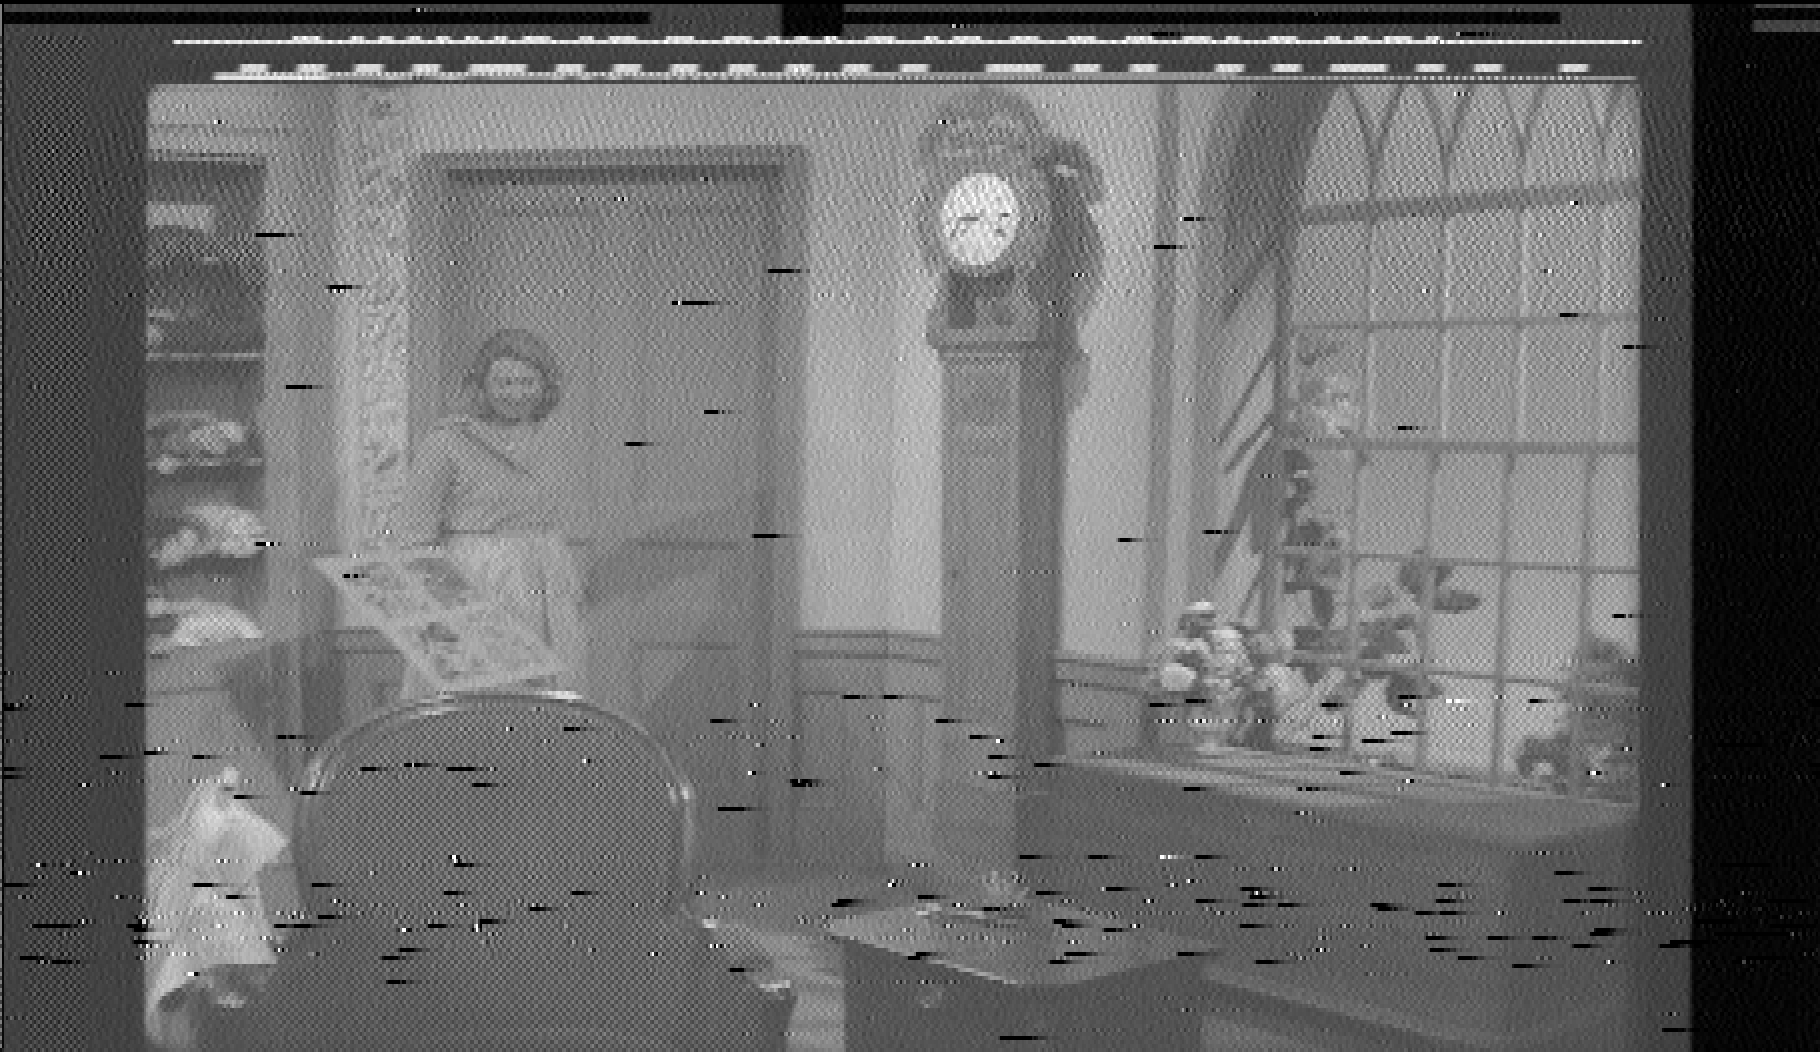

In [21]:
ds1 = fields[1].downscale(lineinfo=llx, final=True)[0]

draw_raw_bwimage(ds1, fields[0].rf.SysParams['outlinelen'], fields[0].linecount, hscale=2, vscale=4)

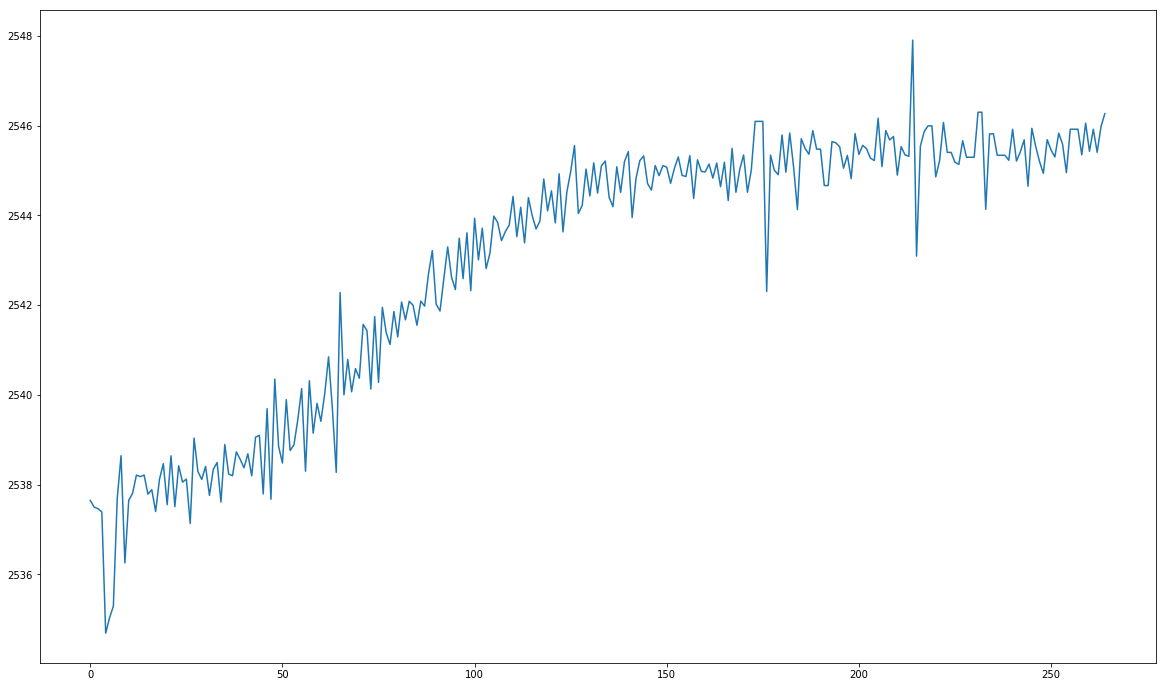

In [23]:
plt.plot(np.diff(llx))

(238420,)
uint8 (262, 910) (262, 910)


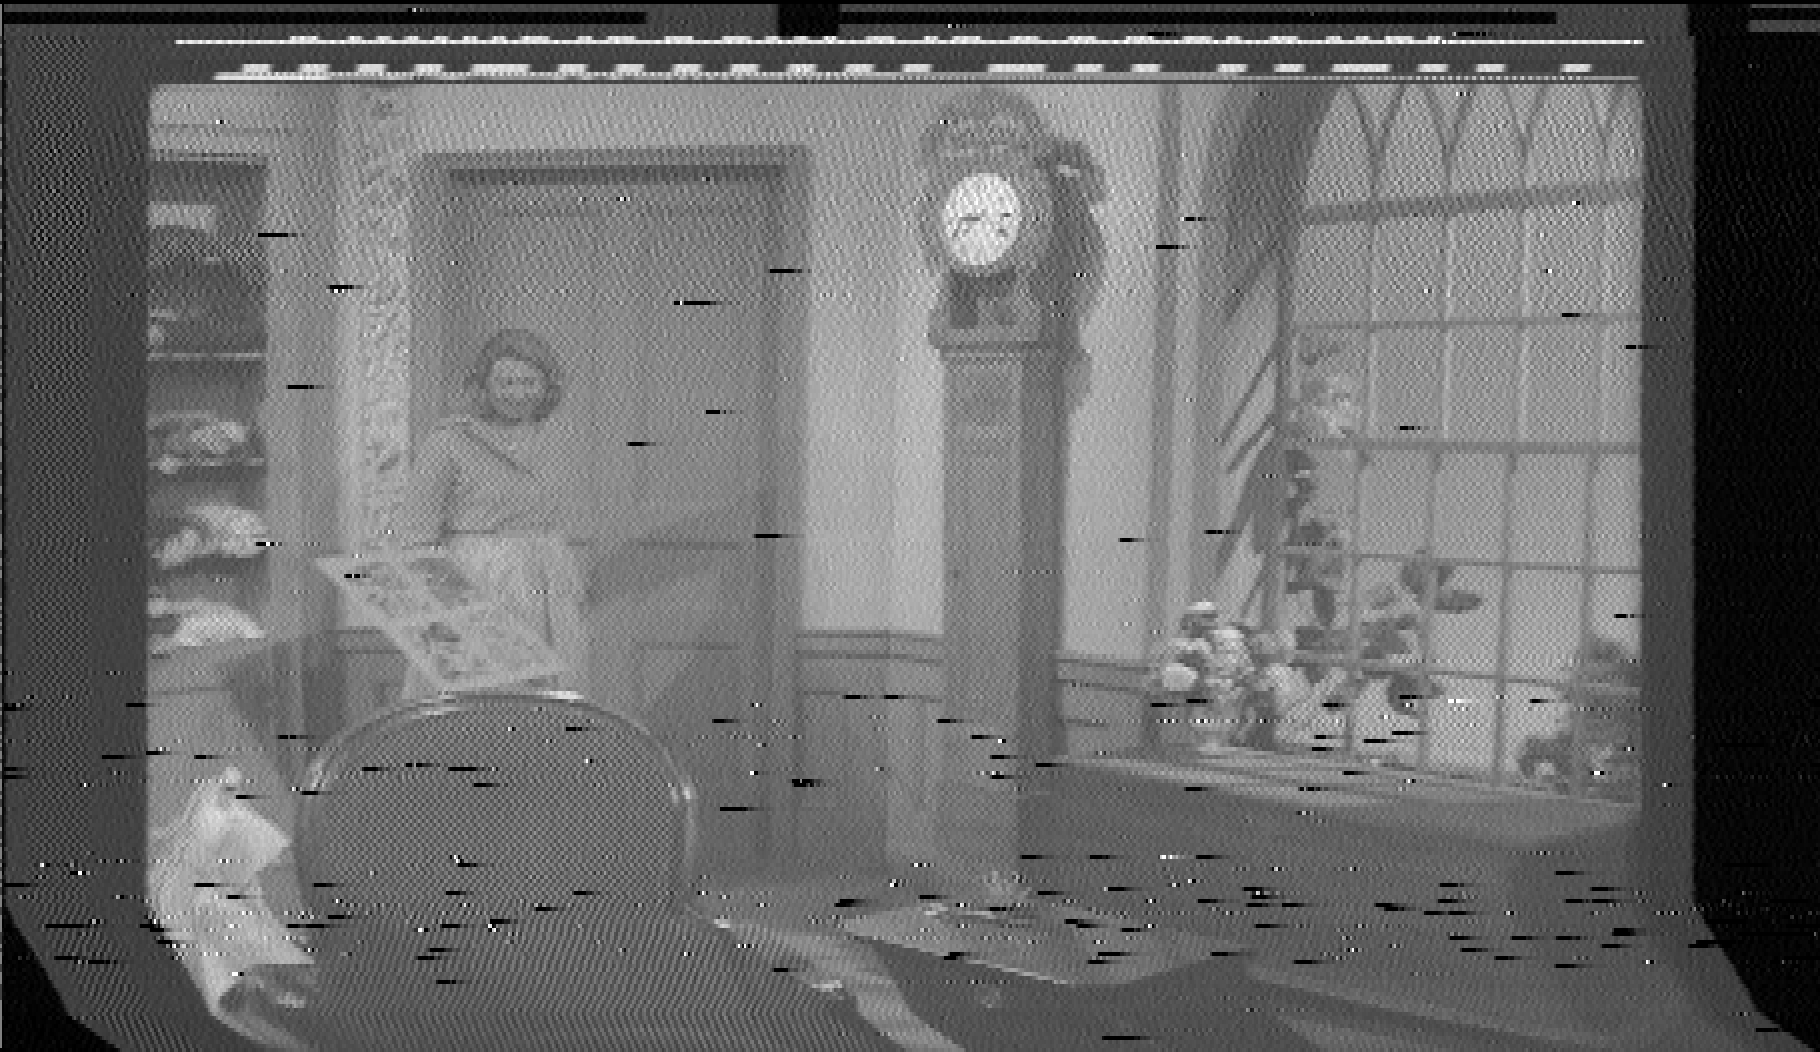

In [15]:
ds1 = fields[1].downscale(final=True)[0]

draw_raw_bwimage(ds1, fields[0].rf.SysParams['outlinelen'], fields[0].linecount, hscale=2, vscale=4)

In [6]:
fields[0]

In [33]:
fields[1].data[0]

array([(8156894.85542043, 7790996.86123455, 0.7338519 ),
       (8177499.95853514, 7803621.89214509, 0.7320224 ),
       (8183718.75099925, 7816859.00097919, 0.72629557), ...,
       (8754738.07863957, 8674636.17010305, 0.00186707),
       (8732363.59486944, 8674054.51268939, 0.00185246),
       (8690276.16974665, 8673415.45979242, 0.00183797)],
      dtype=(numpy.record, [('demod', '<f8'), ('demod_05', '<f8'), ('demod_sync', '<f8')]))

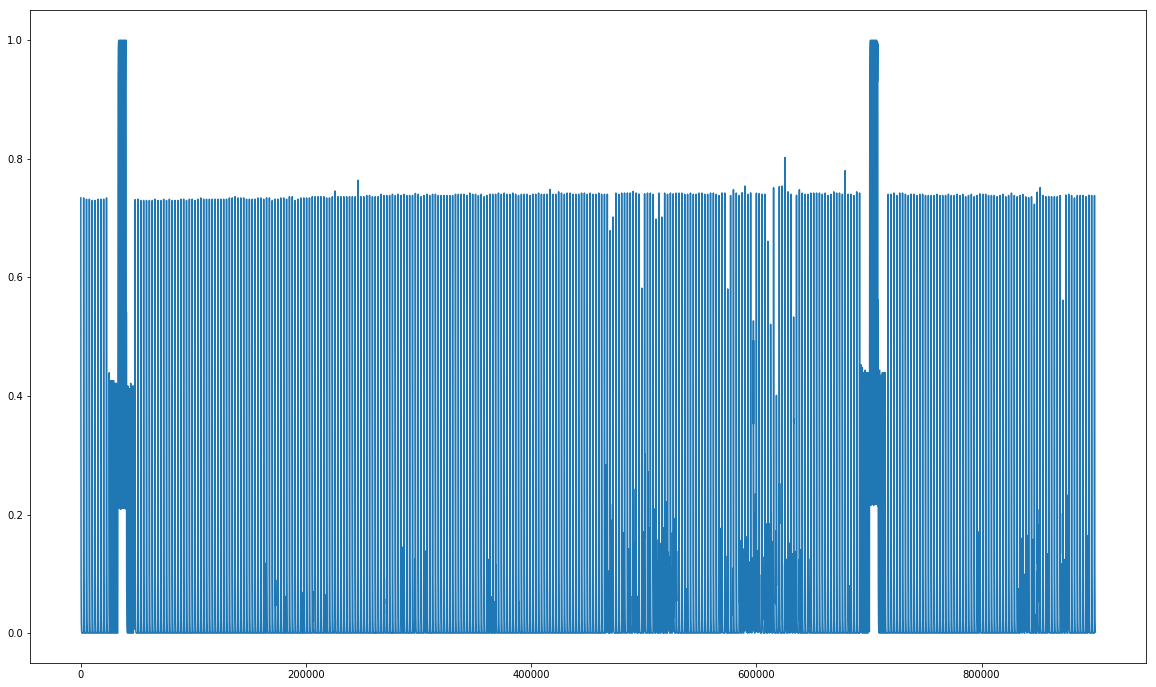

In [34]:
plt.plot(fields[1].data[0]['demod_sync'])

(238420,)
uint8 (262, 910) (262, 910)


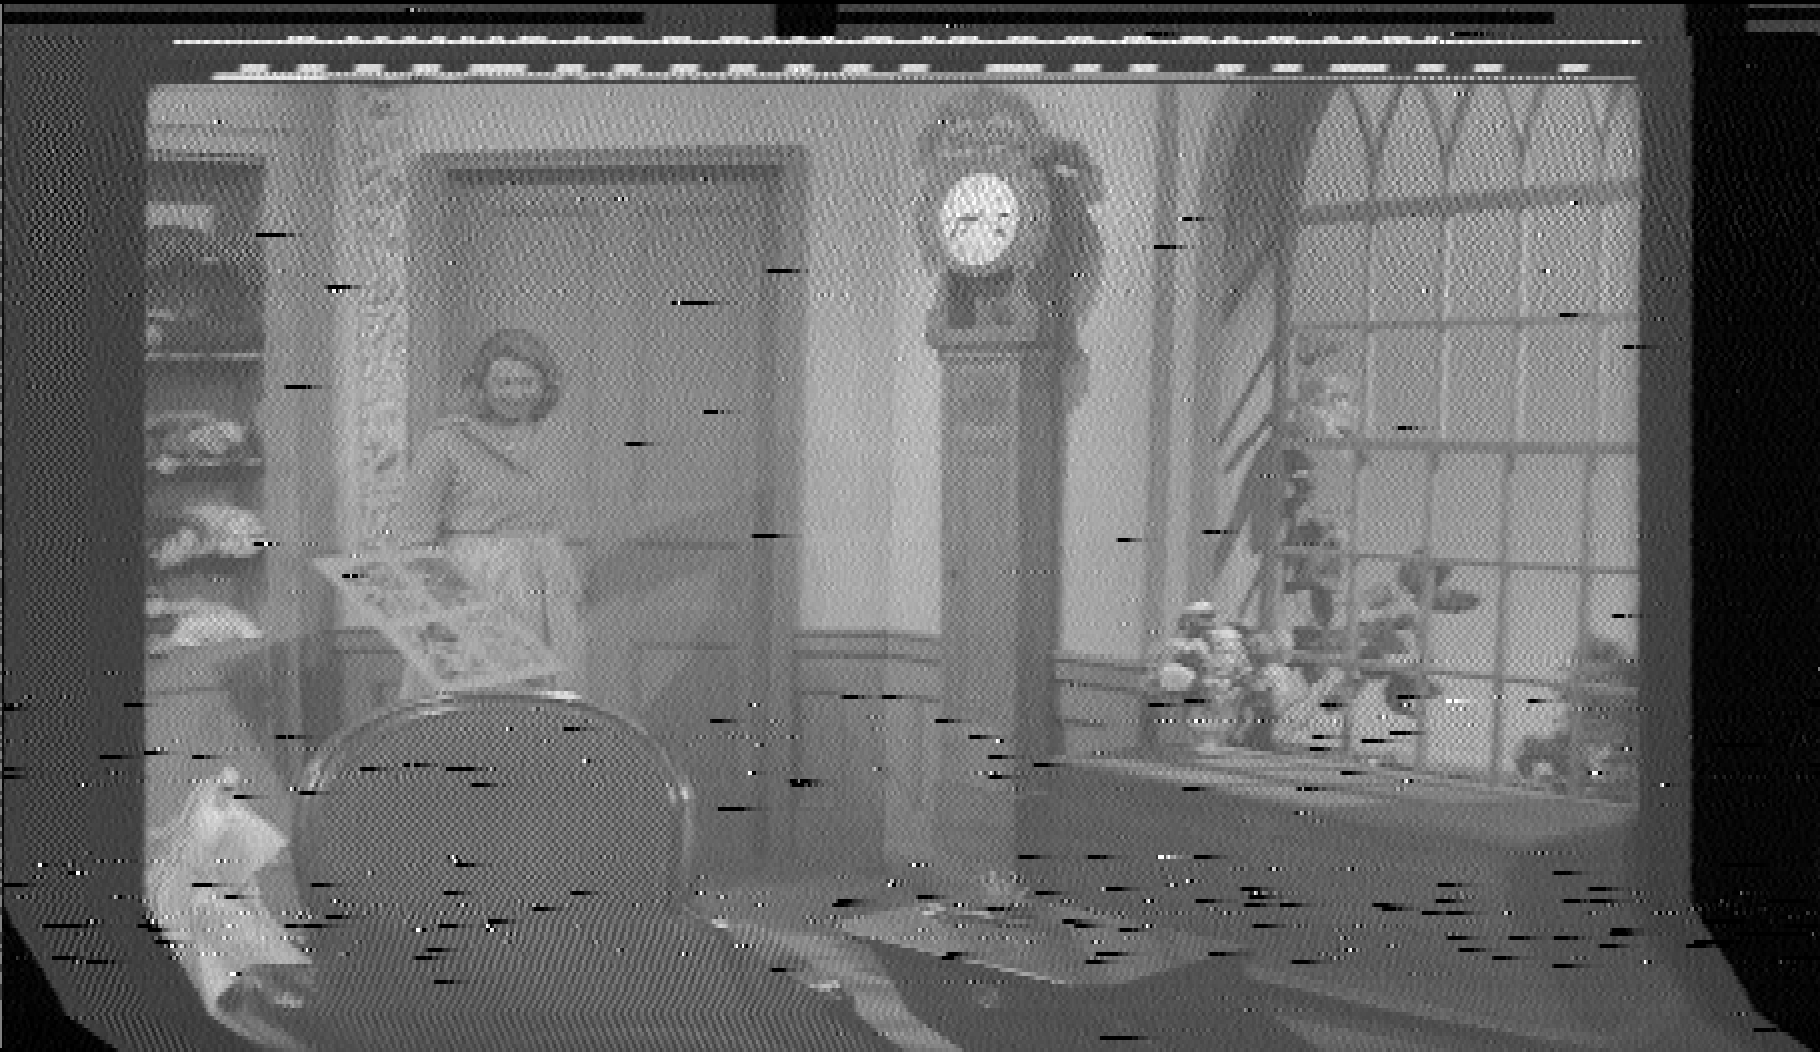

In [25]:
ds1 = fields[1].downscale(lineinfo=ll, final=True)[0]
draw_raw_bwimage(ds1, fields[0].rf.SysParams['outlinelen'], fields[0].linecount, hscale=2, vscale=4)

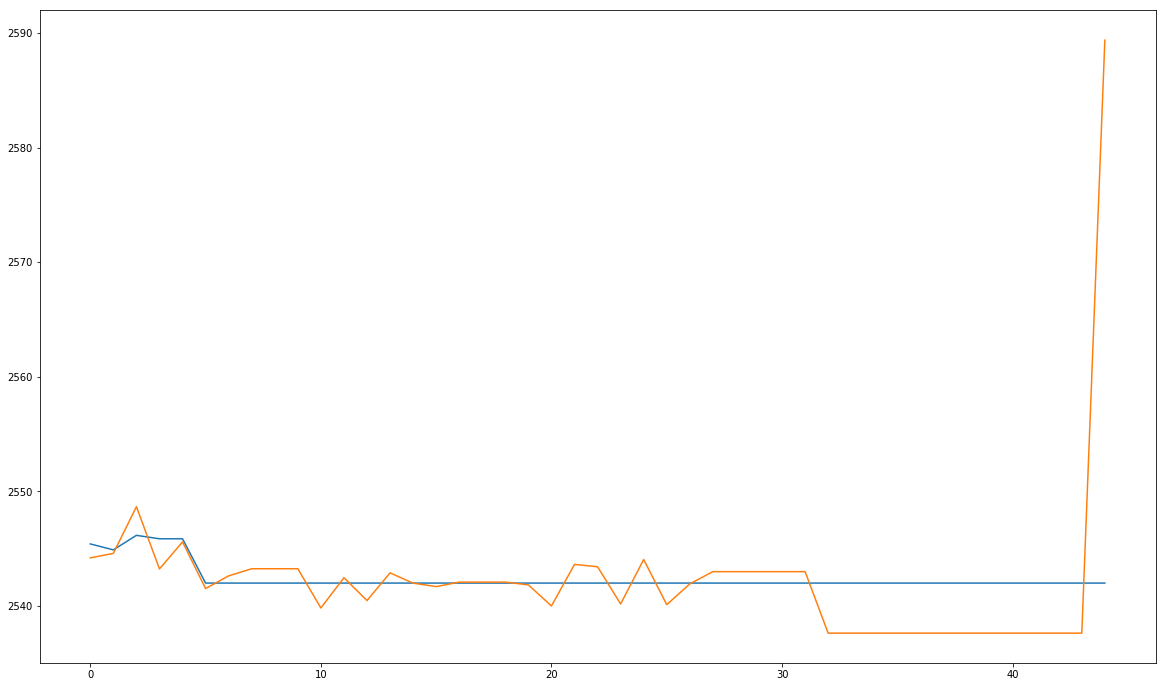

In [15]:
plt.plot(np.diff(fields[1].linelocs[1])[220:])
plt.plot(np.diff(ll)[220:])

In [167]:
rf_pal = ldd.RFDecode(system='PAL')
bytes_per_frame = int(rf_pal.freq_hz / rf_pal.SysParams['FPS'])
framer_pal = ldd.Framer(rf_pal)

infile_pal = open('/home/cpage/ddsftp/Domesday/Simon/LDV4300D_2 Captures/AIV/Domesday_DiscSet2/Domesday Community South_CAV_PAL_side2_Disc set 2_2018-10-02_17-21-20.lds', 'rb')
#infile_pal = open('/mnt3/', 'rb')
#infile_pal = open('/mnt3/palclv.r30', 'rb')
ldd.loader = load_packed_data_4_40

nextsample = 5400003375 + (bytes_per_frame * 0)
nextsample = bytes_per_frame * (3403 + 295 + 6)
#nextsample = bytes_per_frame * 20

nextsample = (bytes_per_frame * (3403 + 295 + 6)) + 1486353

nextsample = 11195072399

outfile = open('tmppal.tbc', 'wb')
outfile_audio = open('tmppal.pcm', 'wb')

allaudio = []

for f in range(0,1):
    combined, audio, firstsample, nextsample, fields = framer_pal.readframe(infile_pal, nextsample, f == 0)
    
    outfile.write(combined)
    outfile_audio.write(audio)
    allaudio.append(audio)

#draw_raw_bwimage(combined, outwidth, 610, hscale=2, vscale=2)

outfile.close()
outfile_audio.close()

11195072399
11196672400
11197470955


(692350,)
uint8 (610, 1135) (610, 1135)


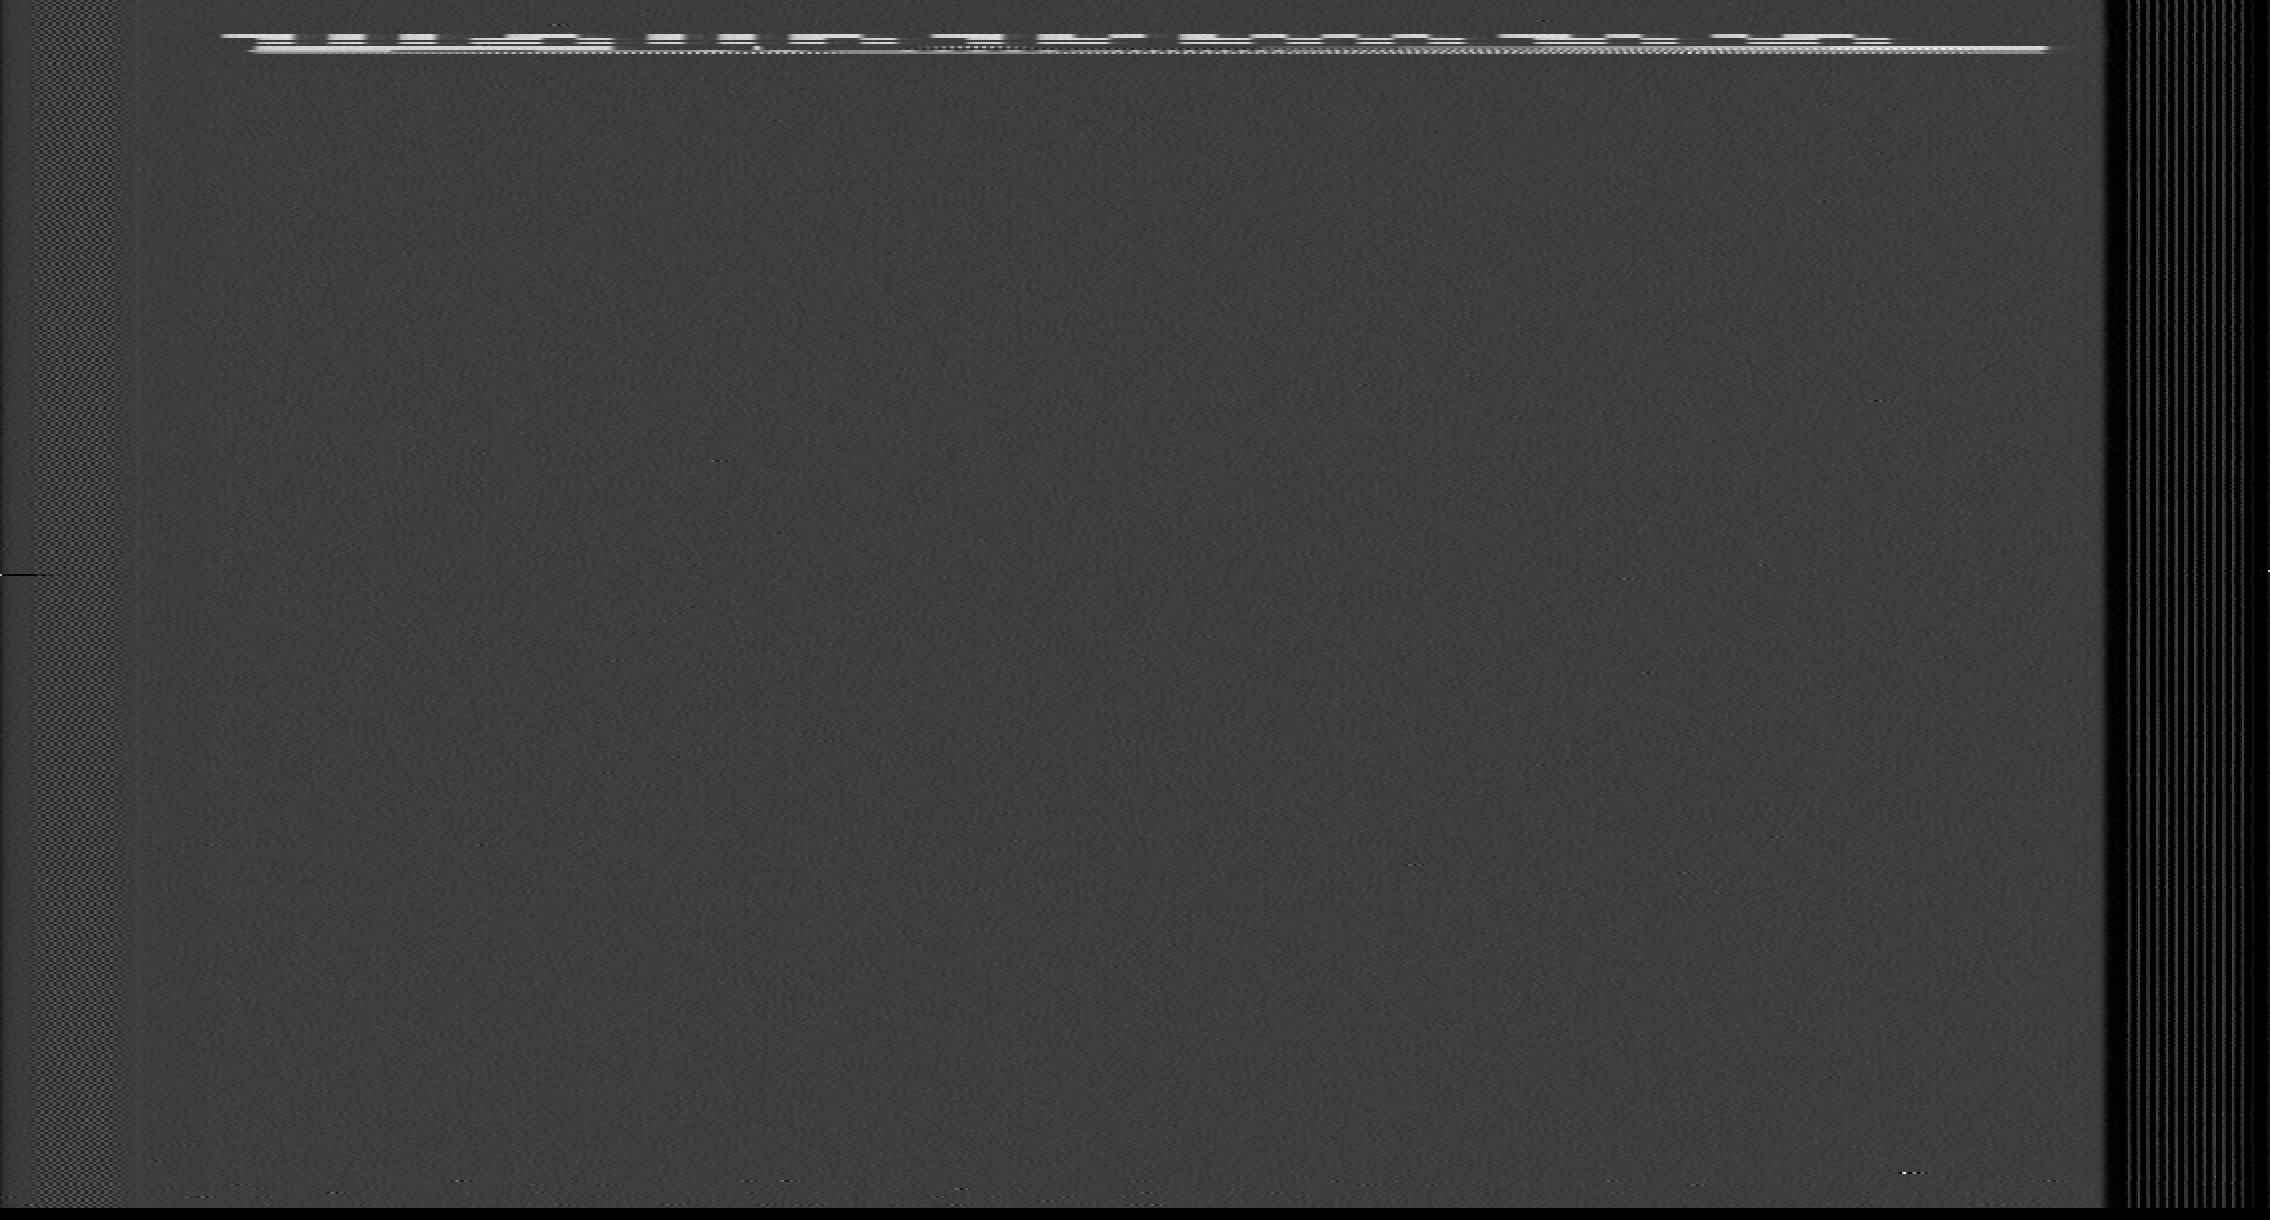

In [15]:
draw_raw_bwimage(combined, 1135, 610, hscale=2, vscale=2)

In [24]:
data = rf_pal.demod(infile_pal, (bytes_per_frame * (3403 + 295 + 6)) + 1486353, 3000000)

fp = ldd.FieldPAL(rf_pal, data, 0)

CAV  3410
CAV  3410


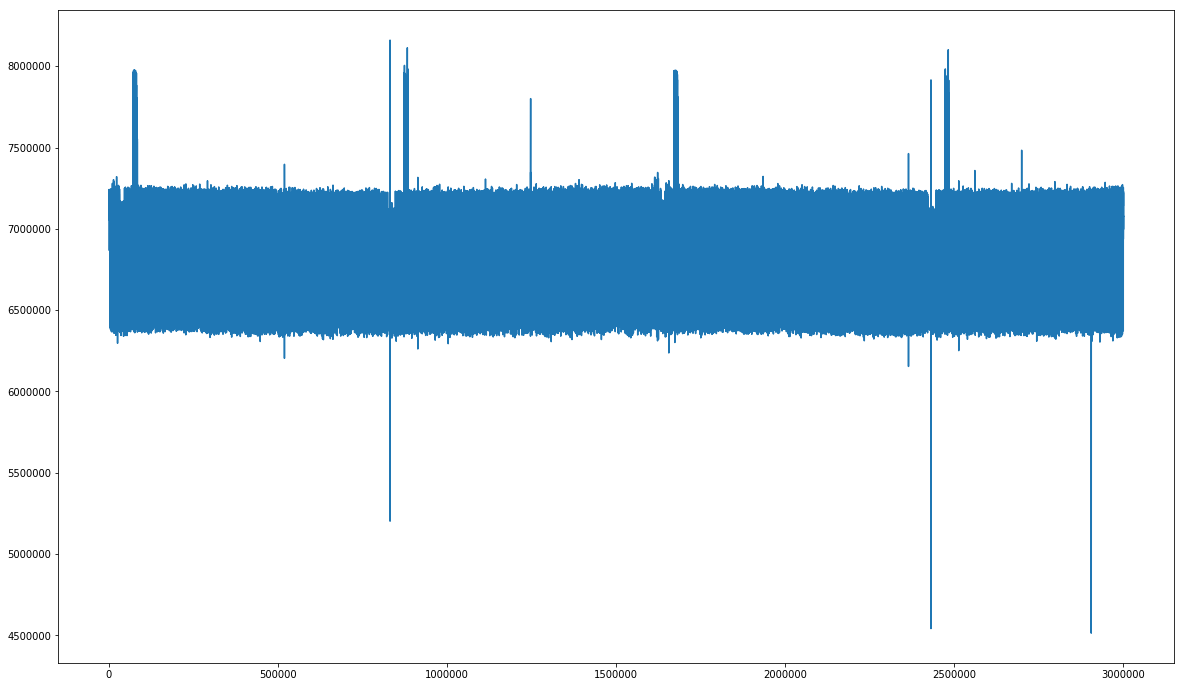

In [30]:
plt.plot(data[0]['demod'][0:])